# Transfer learning with PyTorch 

In this example we'll implement fine-tuning and feature extracting transfer learning using the CIFAR-10 dataset. 

_This example is partially based on_ [https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py](https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py).<br/>
_The licensing information and the author of the base version are:<br/>
License: BSD<br/>
Author: Sasank Chilamkurthy_

Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms

We'll continue with the training and validation batch size:

In [2]:
batch_size = 50

Next, we'll define the train data loader. `train_data_transform` resizes the CIFAR images to match the transfer learning model input size. The function also applies basic data augmentation techniques:

In [4]:
train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=train_data_transform)

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)


Files already downloaded and verified


We'll continue with the validation data loader:

In [5]:
val_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=val_data_transform)

val_order = torch.utils.data.DataLoader(val_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

Files already downloaded and verified


Then we'll select the device (try for GPU, default on CPU):

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's define the training procedure:

In [7]:
def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

We'll continue with the test procedure:

In [8]:
def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

Next, we'll define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the `torchvision.models.resnet18` ImageNet pretrained model. We'll start with feature extracting, which "locks" all model parameters (weights) except for the final fully-connected layer:

In [9]:
def tl_feature_extractor(epochs=5):
    # load the pre-trained model
    model = torchvision.models.resnet18(pretrained=True)

    # exclude existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False

    # newly constructed layers have requires_grad=True by default
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    # transfer to GPU (if available)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()

    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.fc.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc)

    plot_accuracy(test_acc)

We'll continue with the fine-tuning model, which trains all weights of the network:

In [10]:
def tl_fine_tuning(epochs=5):
    # load the pre-trained model
    model = models.resnet18(pretrained=True)

    # replace the last layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    # transfer the model to the GPU
    model = model.to(device)

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc)

    plot_accuracy(test_acc)

Let's define the `plot_accuracy` function:

In [11]:
def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

Finally, we can put everything together and run the training. Let's start with the feature extracting model:

Epoch 1/5
Train Loss: 1.0454; Accuracy: 0.6422
Test Loss: 0.7246; Accuracy: 0.7565
Epoch 2/5
Train Loss: 0.8640; Accuracy: 0.7000
Test Loss: 0.7097; Accuracy: 0.7575
Epoch 3/5
Train Loss: 0.8363; Accuracy: 0.7064
Test Loss: 0.6952; Accuracy: 0.7622
Epoch 4/5
Train Loss: 0.8144; Accuracy: 0.7114
Test Loss: 0.6752; Accuracy: 0.7651
Epoch 5/5
Train Loss: 0.8179; Accuracy: 0.7145
Test Loss: 0.6859; Accuracy: 0.7624


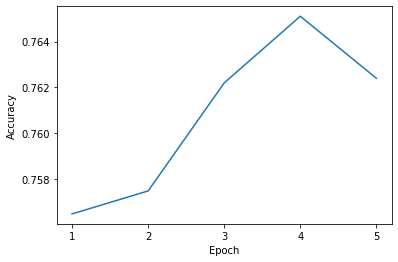

In [13]:
tl_feature_extractor(epochs=5)

We can also run the fine-tuninig model for comparison:

Epoch 1/5
Train Loss: 0.8057; Accuracy: 0.7192
Test Loss: 0.6171; Accuracy: 0.7790
Epoch 2/5
Train Loss: 0.5269; Accuracy: 0.8180
Test Loss: 0.5153; Accuracy: 0.8221
Epoch 3/5
Train Loss: 0.4272; Accuracy: 0.8539
Test Loss: 0.4016; Accuracy: 0.8589
Epoch 4/5
Train Loss: 0.3642; Accuracy: 0.8751
Test Loss: 0.3933; Accuracy: 0.8642
Epoch 5/5
Train Loss: 0.3180; Accuracy: 0.8910
Test Loss: 0.3768; Accuracy: 0.8712


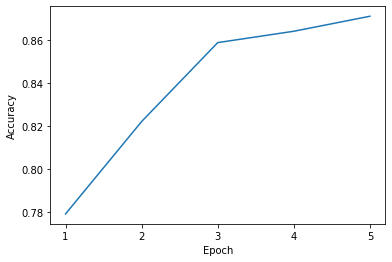

In [14]:
tl_fine_tuning(epochs=5)

The feature extracting model achieves high validation accuracy even after the first epoch, but taps out after that. That's because the model capacity is limited, since only the final fully-connected layer weights are trainable. On the other hand the fine-tuning model uses it's full capacity and achieves higher overall accuracy. 